In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [19]:
actions = [
    'hello',
    'bread_house',
    'lunch',
    # 'NOISE'
]
PATH = '/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/code/lstm'
data = np.concatenate([
    np.load(f'{PATH}/dataset/seq_hello_1703599060.npy'),
    np.load(f'{PATH}/dataset/seq_bread_house_1703599903.npy'),
    np.load(f'{PATH}/dataset/seq_lunch_1703600329.npy'),
    # np.load(f'{PATH}/dataset/seq_NOISE_1703600394.npy')
], axis=0)

data.shape

(2081, 30, 100)

In [20]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2081, 30, 99)
(2081,)


In [21]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2081, 3)

In [22]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1872, 30, 99) (1872, 3)
(209, 30, 99) (209, 3)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                41984     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44163 (172.51 KB)
Trainable params: 44163 (172.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
56/59 [===========================>..] - ETA: 0s - loss: 34.6624 - acc: 0.7656
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models/model.h5
59/59 [==============================] - 2s 18ms/step - loss: 33.1966 - acc: 0.7751 - val_loss: 5.2188e-07 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
10/59 [====>.........................] - ETA: 0s - loss: 0.3339 - acc: 0.9875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/59 [===========================>..] - ETA: 0s - loss: 0.0873 - acc: 0.9945
Epoch 2: val_acc did not improve from 1.00000
59/59 [==============================] - 1s 14ms/step - loss: 0.0851 - acc: 0.9947 - val_loss: 0.0098 - val_acc: 0.9952 - lr: 0.0010
Epoch 3/200
56/59 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 0.9989
Epoch 3: val_acc did not improve from 1.00000
59/59 [==============================] - 1s 13ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 6.2456e-06 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
58/59 [============================>.] - ETA: 0s - loss: 8.0496e-06 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
59/59 [==============================] - 1s 14ms/step - loss: 7.9808e-06 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9952 - lr: 0.0010
Epoch 5/200
57/59 [===========================>..] - ETA: 0s - loss: 7.5580e-05 - acc: 1.0000
Epoch 5: val_acc did not improve from 1.00000
59/59 [==============================] - 1s 14ms/step

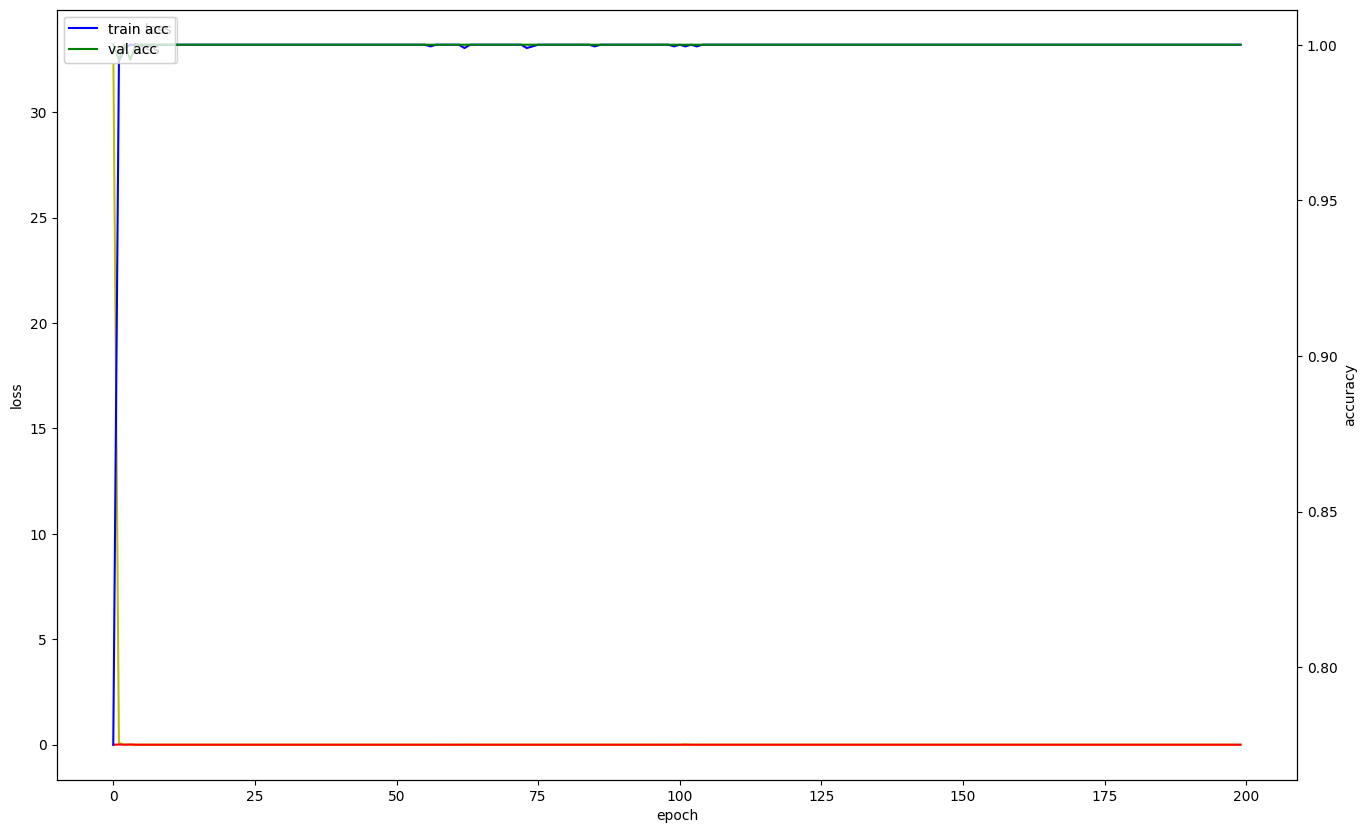

In [25]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [26]:
model.save('/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/model/lstm_test2.h5')

In [27]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model(f'/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/model/lstm_test2.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 [==============================] - 0s 6ms/step


array([[[  0,   0],
        [  0, 209]]])

# test

In [7]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

actions = [
    'hello',
    'bread_house',
    'lunch',
    'NOISE'
]
seq_length = 30

model = load_model(r"C:\PlayData\lstm_test1.h5")

In [8]:

import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

actions = [
    'hello',
    'bread_house',
    'lunch',
    'NOISE'
]
seq_length = 30

# model = load_model('G:\내 드라이브\Sign_Remaster\Sign_Language_Remaster\model\lstm_test1.h5')

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)

# w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# out = cv2.VideoWriter('input.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
# out2 = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))

seq = []
action_seq = []

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # [20, 3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue

            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

            y_pred = model.predict(input_data).squeeze()

            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]

            if conf < 0.9:
                continue

            action = actions[i_pred]
            action_seq.append(action)

            if len(action_seq) < 3:
                continue

            this_action = '?'
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action

            cv2.putText(img, f'{this_action.upper()}', org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

    # out.write(img0)
    # out2.write(img)
    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        break


1/1 [==============================] - 0s 23ms/step


: 